In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PySpark setup

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
# !wget https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

In [2]:
# !tar xzvf spark-3.5.0-bin-hadoop3.tgz

In [4]:
!pip install -q findspark

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [6]:
import findspark
findspark.init()

In [7]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, avg, when
import pandas as pd

In [8]:
sc = pyspark.SparkContext('local[*]')
spark = SparkSession(sc)
spark

# Upload data

In [9]:
%cd drive/MyDrive/MMDB

/content/drive/MyDrive/MMDB


In [10]:
# !tar xzvf sample.tgz

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [328]:
# with open('sample_unique_users.jsonl', 'r') as fin:
#     samples = list(map(json.loads, fin.readlines()))

In [13]:
with open('sample.jsonl', 'r') as fin:
    samples_1 = list(map(json.loads, fin.readlines()))

In [591]:
# with open('sample_wikidata_15000sec.jsonl', 'r') as fin:
#     samples_2 = list(map(json.loads, fin.readlines()))

In [14]:
df = spark.createDataFrame(samples_1)

In [546]:
# df.columns

In [15]:
df.show(5)

+--------------------+-----+--------------------+----------+--------------------+--------------------+-----+---------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+----------+--------------------+--------------------+----+--------------------+------+
|             $schema|  bot|             comment|        id|              length|                meta|minor|namespace|          notify_url|       parsedcomment|            revision|     server_name|server_script_path|          server_url| timestamp|               title|           title_url|type|                user|  wiki|
+--------------------+-----+--------------------+----------+--------------------+--------------------+-----+---------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+----------+--------------------+--------------------+----+--------------------+------+
|/mediawiki/recent...|fal

In [16]:
df.count()

17625

# Describe the distribution of edits per users and bots

In [17]:
df_bot_distr = df.select('user', 'bot').toPandas().drop_duplicates()

In [18]:
df_bot_distr['bot'].value_counts()

False    3156
True       51
Name: bot, dtype: int64

Text(0, 0.5, '% of users/bots')

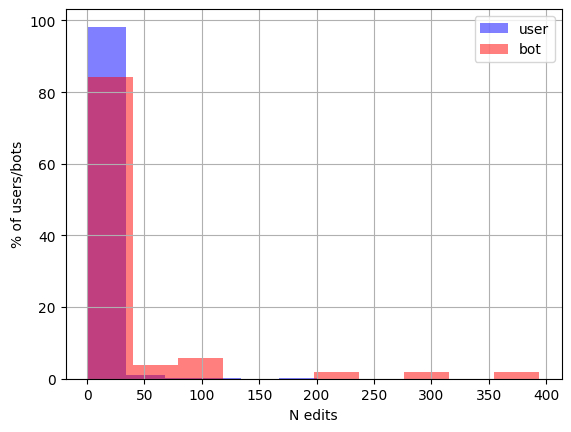

In [19]:
ax1 = plt.subplot(111)
df_distr = df.groupBy('user', 'bot').count().toPandas()
df_bots = df_distr[df_distr['bot']==True]
df_users = df_distr[df_distr['bot']==False]

df_users['count'].hist(ax=ax1, weights=100 * np.ones(len(df_users)) / len(df_users),
                       label='user', color='blue', alpha=0.5)
df_bots['count'].hist(ax=ax1, weights=100 * np.ones(len(df_bots)) / len(df_bots),
                      label='bot', color='red', alpha=0.5)

ax1.legend(loc='best')
# ax1.set_ylim((0, 100))
ax1.set_xlabel('N edits')
ax1.set_ylabel('% of users/bots')

Text(0, 0.5, 'N of users/bots')

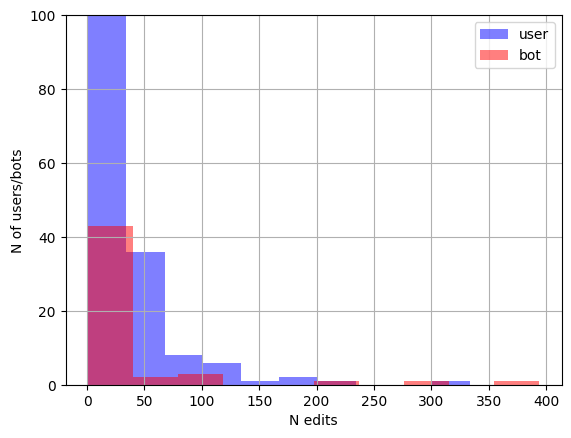

In [20]:
ax1 = plt.subplot(111)
df_distr = df.groupBy('user', 'bot').count().toPandas()
df_bots = df_distr[df_distr['bot']==True]
df_users = df_distr[df_distr['bot']==False]

df_users['count'].hist(ax=ax1,
                       label='user', color='blue', alpha=0.5)
df_bots['count'].hist(ax=ax1,
                      label='bot', color='red', alpha=0.5)

ax1.legend(loc='best')
ax1.set_ylim((0, 100))
ax1.set_xlabel('N edits')
ax1.set_ylabel('N of users/bots')

# Train bot detection model

### difference length

In [21]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# the average length of all edits per user as a feature
@udf(IntegerType())
def diff_length(length):
  old = length['old']
  new = length['new']
  return abs(new - old)

In [22]:
df = df.withColumn("length_difference", diff_length(df["length"]))

### difference revision

In [555]:
# # the average diff in revision of all edits per user as a feature
# @udf(IntegerType())
# def diff_revision(revision):
#   old = revision['old']
#   new = revision['new']
#   return abs(new - old)

In [556]:
# df = df.withColumn("revision_difference", diff_length(df["revision"]))

In [23]:
df = df.select('bot', 'user', "length_difference")

In [24]:
from pyspark.sql.functions import count, mean, first

grouped_df = df.groupBy("user").agg(
    count("user").alias("count"),
    mean("length_difference").alias("mean_length_difference"),
    # mean("revision_difference").alias("mean_revision_difference"),
    first("bot").alias("bot")
)

In [25]:
grouped_df.show(5)

+-------------+-----+----------------------+-----+
|         user|count|mean_length_difference|  bot|
+-------------+-----+----------------------+-----+
| 87.1.186.178|    5|                   4.2|false|
|  ThatOneWolf|   22|     557.4090909090909|false|
|   JackkBrown|  110|    18.136363636363637|false|
|      Wes3803|   11|     84.81818181818181|false|
|31.221.89.146|    8|               501.375|false|
+-------------+-----+----------------------+-----+
only showing top 5 rows



In [26]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when

assembler = VectorAssembler(
  inputCols=["count", "mean_length_difference"], outputCol="features"
)

assembled = assembler.transform(grouped_df)

In [27]:
assembled = assembled.withColumnRenamed("bot", "label").select('features', 'label', 'user')
assembled = assembled.withColumn('label', when(assembled.label, 1.0).otherwise(0.0))

In [28]:
assembled.show(5)

+--------------------+-----+-------------+
|            features|label|         user|
+--------------------+-----+-------------+
|           [5.0,4.2]|  0.0| 87.1.186.178|
|[22.0,557.4090909...|  0.0|  ThatOneWolf|
|[110.0,18.1363636...|  0.0|   JackkBrown|
|[11.0,84.81818181...|  0.0|      Wes3803|
|       [8.0,501.375]|  0.0|31.221.89.146|
+--------------------+-----+-------------+
only showing top 5 rows



Note: \
train and test set - used for bot detection classifier; \
validation set - used for inference of the model and BloomFilter

In [563]:
# for sample_unique_users.jsonl
# train_df, test_df = assembled.randomSplit(weights=[0.6,0.4], seed=10)
# valid_df, test_df = test_df.randomSplit(weights=[0.5, 0.5], seed=10)

In [29]:
# for sample.jsonl
train_df, test_df = assembled.randomSplit(weights=[0.7,0.3], seed=100)
valid_df, test_df = test_df.randomSplit(weights=[0.5, 0.5], seed=100)

In [30]:
train_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 2202|
|  1.0|   39|
+-----+-----+



In [31]:
test_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  470|
|  1.0|    5|
+-----+-----+



In [32]:
valid_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  482|
|  1.0|    7|
+-----+-----+



In [33]:
train_df.count(), test_df.count(), valid_df.count()

(2241, 475, 489)

## undersampling + updsampling
Upsamping: copy 3 times bots \
Undersampling: took a sample of users which 10 times bigger than amount as upsampled bots

In [34]:
df_pandas = train_df.toPandas()

In [570]:
# for sample_unique_users.jsonl
# df_bots_pandas = df_pandas[df_pandas['label']==1.0]
# df_bots_pandas = pd.concat([df_bots_pandas, df_bots_pandas])

# df_users_pandas = df_pandas[df_pandas['label']==0.0].sample(n=20*len(df_bots_pandas))

# df_pandas_new_sample = pd.concat([df_users_pandas, df_bots_pandas])
# df_pandas_new_sample = df_pandas_new_sample.sample(frac = 1)

# df_pandas_new_sample['label'].value_counts()

In [35]:
# for sample.jsonl
df_bots_pandas = df_pandas[df_pandas['label']==1.0]
df_bots_pandas = pd.concat([df_bots_pandas, df_bots_pandas, df_bots_pandas])

df_users_pandas = df_pandas[df_pandas['label']==0.0].sample(n=10*len(df_bots_pandas))

df_pandas_new_sample = pd.concat([df_users_pandas, df_bots_pandas])
df_pandas_new_sample = df_pandas_new_sample.sample(frac = 1)

df_pandas_new_sample['label'].value_counts()

0.0    1170
1.0     117
Name: label, dtype: int64

In [36]:
df_train_aug = spark.createDataFrame(df_pandas_new_sample)

In [37]:
df_train_aug.show(5)

+------------+-----+--------------------+
|    features|label|                user|
+------------+-----+--------------------+
| [3.0,189.0]|  0.0|        100.15.83.54|
|[1.0,1872.0]|  0.0|          HaskelleTW|
|   [1.0,1.0]|  0.0|   UltrasonicMadness|
|  [2.0,21.0]|  0.0|2001:B011:7C05:1E...|
|   [1.0,1.0]|  0.0|2603:7000:4400:DB...|
+------------+-----+--------------------+
only showing top 5 rows



## training

In [38]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

In [39]:
model = rf.fit(df_train_aug)

## test set predictions

In [40]:
predictions = model.transform(test_df)

In [41]:
df_pred = predictions.select('features', 'prediction', 'label').toPandas()

In [42]:
df_pred['prediction'].value_counts()

0.0    468
1.0      7
Name: prediction, dtype: int64

In [43]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction")
metrics = MulticlassMetrics(predictions.select("prediction", "label").rdd)

# print(metrics.confusionMatrix().toArray())
print("Precision bot-class: ", metrics.precision(1.0))
print("Precision user-class: ", metrics.precision(0.0))
print("Recall bot-class: ", metrics.recall(1.0))
print("Recall user-class: ", metrics.recall(0.0))
print("Weighted F1-score: ", metrics.weightedFMeasure())

/content/spark-3.5.0-bin-hadoop3/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision bot-class:  0.2857142857142857
Precision user-class:  0.9935897435897436
Recall bot-class:  0.4
Recall user-class:  0.9893617021276596
Weighted F1-score:  0.9845434481726704


## validation set predictions

In [44]:
predictions = model.transform(valid_df)

In [45]:
df_pred_validation = predictions.select('user', 'prediction', 'label').toPandas()

In [46]:
df_pred_validation['prediction'].value_counts()

0.0    482
1.0      7
Name: prediction, dtype: int64

In [47]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction")
metrics = MulticlassMetrics(predictions.select("prediction", "label").rdd)

# print(metrics.confusionMatrix().toArray())
print("Precision bot-class: ", metrics.precision(1.0))
print("Precision user-class: ", metrics.precision(0.0))
print("Recall bot-class: ", metrics.recall(1.0))
print("Recall user-class: ", metrics.recall(0.0))
print("Weighted F1-score: ", metrics.weightedFMeasure())

/content/spark-3.5.0-bin-hadoop3/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision bot-class:  0.14285714285714285
Precision user-class:  0.9875518672199171
Recall bot-class:  0.14285714285714285
Recall user-class:  0.9875518672199171
Weighted F1-score:  0.9754601226993864


In [48]:
df_pred_validation

,user,prediction,label
0,207.213.88.194,0.0,0.0
1,2401:7400:601B:5BE1:1799:4AC2:D289:5382,0.0,0.0
2,2600:8806:910C:8100:3070:D508:9698:66AE,0.0,0.0
3,2601:100:8780:2490:7C6B:9B2C:1325:9ADD,0.0,0.0
4,2605:A601:A936:1800:C137:F716:36E0:20E6,0.0,0.0
...,...,...,...
484,Kaltenmeyer,0.0,0.0
485,TheLonelyPather,0.0,0.0
486,Plantdrew,0.0,0.0
487,Materialscientist,1.0,0.0
